# "Standard Candle" Toy 4: Multi-Channel MNIST

Have multiple MNIST channels being fed in, where each input channel is a separate MNIST drawn digit but from the same class. The output of the network is a single MNIST class prediction across all the MNIST image channels.

Note that this notebook should be run from the `notebooks/` subdirectory.

## Setup

In [83]:
# NOTE: Change this to what the notebook name is for each experiment to ensure
# training results are saved into the right sub-directory.
notebook_name = '04b_simple_toy1'

from collections import namedtuple, defaultdict
import math
import random
import os
import shutil

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image

In [84]:
# Protective code to ensure we always reset the random seed when doing training, or else
# code won't be reproducible.
if 'training_runs_count' not in globals():
  training_runs_count = 0
if 'seed_reset_count' not in globals():
  seed_reset_count = 0

# Path to data and training results.
root_path = '../..' # Relative to: notebooks/01b_simple_toy
data_path = os.path.join(root_path, 'data', notebook_name)
results_path = os.path.join(root_path, 'training_results', notebook_name)
model_path = os.path.join(results_path, 'model.pth')
optimizer_path = os.path.join(results_path, 'optimizer.pth')

for path in [data_path, results_path]:
  if not os.path.exists(path):
    print('{} does not exist; creating directory...'.format(os.path.abspath(path)))
    os.makedirs(path)

n_epochs = 8
batch_size_train = 64
batch_size_test = 1000
log_interval = 10

# Number of MNIST images given to the network at once.
# TODO: Try a larger number of channels.
num_channels = 2

In [85]:
# Use the GPU.
cuda_device = 0
torch.backends.cudnn.enabled = True
if not torch.cuda.is_available():
  raise RuntimeError("CUDA not available! Unable to continue")
# Force ourselves to use only one GPU.
device = torch.device("cuda:{}".format(cuda_device))
print("Using device {} for training, current device: {}, total devices: {}".format(
  device, torch.cuda.current_device(), torch.cuda.device_count()))

# Force runs to be deterministic and reproducible.
random_seed = 1
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(random_seed)
seed_reset_count += 1

Using device cuda:0 for training, current device: 0, total devices: 6


In [86]:
"""
Custom pytorch dataset that returns multi-channel MNIST results all of the same class (0 through 9) but
with different hand-drawn images as each channel. Also applies a random brightness factor to each image.
"""
class MultiChannelBrightnessMNIST(torchvision.datasets.MNIST):
  
  SampleTuple = namedtuple("Sample", "image orig_image target brightness")
  
  # TODO: Use dynamic arguments to super() to not have to hard code these params
  # from torchvision.datsets.MNIST.
  def __init__(self, root, num_channels=num_channels,
               train=True, transform=None, target_transform=None, download=False):
    super(MultiChannelBrightnessMNIST, self).__init__(
      root, train, transform, target_transform, download)

    self._num_channels = num_channels
    self._setup_samples()
    self._compute_statistics()

  def _setup_samples(self):
    """
    Re-organizes the data into tuples of the following form to make them easier to work with,
    as well as to record what the random brightness is for correctly generating statistics
    and ground truth information:

    (image, orig_image, target, brightness)

    Also creates a hashtable that goes from the target class to all available image tuples
    with those classes so we can quickly fetch images of the same class together.
    """
    self._available_samples = defaultdict(lambda: [])
    self._all_samples = []
    for (image, target) in zip(self.data, self.targets):
      brightness = self._compute_brightness()

      # Our loss function currently assumes that all brightness values are in the
      # range [0.0, 1.0]. If this assumption is broken make sure we know so that
      # in the future we can do extra work to 'squash' brightness values back
      # down to [0.0, 1.0]
      assert brightness >= 0.0 and brightness <= 1.0,
        "Brightness must be in the range [0.0, 1.0] for the loss function to work"
      
      darker_image = self._darken_image(brightness, image)

      sample = self.SampleTuple(image=darker_image, orig_image=image, target=target,
                                brightness=brightness)

      assert isinstance(target, torch.Tensor), "Expected Torch Tensor type!"
      self._available_samples[target.item()].append(sample)
      self._all_samples.append(sample)
      
  def _compute_brightness(self):
    # Randomly compute what the brightness setting should be for each sample.
    # NOTE: Below 30% brightness accuracy degrades vs. the experiment 2 baseline.
    return np.round((0.3 - 1.0) * np.random.random_sample() + 1.0, decimals=2)

  def _darken_image(self, brightness, img):
    brightness = torch.tensor(brightness)
    return img.double().mul(brightness).byte()
  
  def _compute_statistics(self):
    """
    Compute global mean and standard deviation for data input normalization.
    """
    max_pixel_value = 255.0
    means = np.zeros((len(self._all_samples)), dtype=np.float)
    stds = np.zeros((len(self._all_samples)), dtype=np.float)
    for idx, sample in enumerate(self._all_samples):
      np_img = np.array(sample.image, dtype=np.float)
      means[idx] = np.round((np_img / max_pixel_value).mean(), decimals=4)
      stds[idx] = np.round((np_img / max_pixel_value).std(), decimals=4)

    self.global_mean = np.round(np.sum(means) / len(means), decimals=4)
    self.global_std = np.round(np.sum(stds) / len(means), decimals=4)
    
    # Ensure our computed mean and std are within what we've seen historically;
    # otherwise flag this as a potential bug.
    assert self.global_mean >= 0.05 and self.global_mean <= 0.2,
      "Computed global mean is outside historical ranges seen: {}".format(
        self.global_mean)
    assert self.global_std >= 0.1 and self.global_std <= 0.4,
      "Computed global std is outside historical ranges seen: {}".format(
        self.global_std)
    
  def __getitem__(self, index):
    # NOTE: We return items in bunches of num_channels. We also essentially
    # ignore the index and just return random bunches of the same class.

    # Randomly choose a class label.
    target_class = np.random.randint(low=0, high=10)
    samples_with_class = self._available_samples[target_class]
    
    # Fetch num_channel samples that have this target class.
    result_idxs = np.random.choice(len(samples_with_class), size=(self._num_channels,),
                                   replace=False)
    results = [samples_with_class[idx] for idx in result_idxs]
    
    # NOTE: If we don't cast back into a PIL Image we lose some precision vs. experiment 2; this is
    # probably due to some image processing or slight byte conversion happening inside of PIL image.
    # TODO: See if this is still needed in experiment 4+.
    results = [self.SampleTuple(image=Image.fromarray(sample.image.numpy(), mode='L'),
                                orig_image=sample.orig_image,
                                target=sample.target,
                                brightness=sample.brightness) for sample in results]
    
    if self.transform is not None:
      results = [self.SampleTuple(image=self.transform(sample.image),
                                  orig_image=sample.orig_image,
                                  target=sample.target,
                                  brightness=sample.brightness) for sample in results]
      

    if self.target_transform is not None:
      results = [self.SampleTuple(image=self.target_transform(sample.image),
                                  orig_image=sample.orig_image,
                                  target=sample.target,
                                  brightness=sample.brightness) for sample in results]
    
    # Turn the images into a single multi-channel image.
    height = 28
    width = 28
    multi_channel_img = torch.tensor(np.zeros((self._num_channels, height, width)),
                                     dtype=torch.float32)
    for idx, sample in enumerate(results):
      multi_channel_img[idx] = torch.tensor(np.array(sample.image), dtype=torch.float32)

    # Make sure we don't accidentally mix classes in our results.
    assert len(list(filter(lambda sample: sample.target != target_class, results))) == 0, \
           "Classes are getting mixed up in dataset results!"
    
    debug_results = results

    return multi_channel_img, target_class, debug_results
  
  def __len__(self):
    return math.floor(len(self.data) / self._num_channels)

In [87]:
# Randomly choose a class label.
target_class = np.random.randint(low=0, high=10)
samples_with_class = training_data._available_samples[target_class]

# Fetch num_channel samples that have this target class.
result_idxs = np.random.choice(len(samples_with_class), size=(training_data._num_channels,), replace=False)
results = [samples_with_class[idx] for idx in result_idxs]

# NOTE: If we don't cast back into a PIL Image we lose some precision vs. experiment 2; this is
# probably due to some image processing or slight byte conversion happening inside of PIL image.
# TODO: See if this is still needed in experiment 4+.
results = [training_data.SampleTuple(
                            image=Image.fromarray(sample.image.numpy(), mode='L'),
                            orig_image=sample.orig_image,
                            target=sample.target,
                            brightness=sample.brightness) for sample in results]

if training_data.transform is not None:
  results = [training_data.SampleTuple(
                              image=training_data.transform(sample.image),
                              orig_image=sample.orig_image,
                              target=sample.target,
                              brightness=sample.brightness) for sample in results]


if training_data.target_transform is not None:
  results = [training_data.SampleTuple(
                              image=training_data.target_transform(sample.image),
                              orig_image=sample.orig_image,
                              target=sample.target,
                              brightness=sample.brightness) for sample in results]

# Turn the images into a single multi-channel image.
height = 28
width = 28
multi_channel_img = torch.tensor(np.zeros((training_data._num_channels, height, 
                                           width)), dtype=torch.float32)
for idx, sample in enumerate(results):
  multi_channel_img[idx] = torch.tensor(np.array(sample.image), dtype=torch.float32)

# Make sure we don't accidentally mix classes in our results.
  assert len(list(filter(lambda sample: sample.target != target_class, results))) == 0, \
         "Classes are getting mixed up in dataset results!"

In [89]:
# TODO: See if setting num_workers > 1 or using pin_memory can help with CPU/GPU transfers.

training_data = MultiChannelBrightnessMNIST(data_path, num_channels=num_channels,
                                            train=True, download=True)

print("Computed MNIST global mean over training data: {}".format(training_data.global_mean))
print("Computed MNIST std over training data: {}".format(training_data.global_std))

training_data.transform = transforms = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((training_data.global_mean,), (training_data.global_std,))
])

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
  MultiChannelBrightnessMNIST(data_path, num_channels=num_channels,
                              train=False, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((training_data.global_mean,), (training_data.global_std,))
  ])),
  batch_size=batch_size_test, shuffle=True)

Computed MNIST global mean over training data: 0.0846
Computed MNIST std over training data: 0.1953


In [90]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net, self).__init__()
    self.num_channels = num_channels

    # TODO: Try this _without_ expanding the size of all the downstream channels
    # by num_channels; perhaps we don't need this extra expanded capacity.
    self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=10 * num_channels,
                           kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=10 * num_channels, out_channels=20 * num_channels,
                           kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(in_features=320 * num_channels, out_features=50 * num_channels)
    self.fc2 = nn.Linear(in_features=50 * num_channels, out_features=10)
    
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), kernel_size=2))
    x = x.view(-1, 320 * self.num_channels)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

model = Net(num_channels)
model.cuda()

# Use a second-order optimizer like Adam so that we don't need to deal with things
# like learning rates and momentum.
optimizer = torch.optim.Adam(model.parameters())

train_losses, train_counter, test_losses = [], [], []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets, example_debug) = next(examples)

def train(epoch):
  model.train()
  for batch_idx, (data, target, debug) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    output = output.to(device)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100.0 * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
      torch.save(model.state_dict(), model_path)
      torch.save(optimizer.state_dict(), optimizer_path)

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target, debug in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      output = output.to(device)
      # TODO: Handle the deprecation warning for log_softmax needing an explicit 'dim' argument
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100.0 * correct / len(test_loader.dataset)))

## Do the actual training

In [91]:
# To ensure reproducibility, ensure we never attempt to train without also reseting the random seed every time.
if training_runs_count >= seed_reset_count:
  msg = "You didn't reset the random seed! Runs won't be reproducible. Re-run reseting random seed."
  raise Exception(msg)

training_runs_count += 1

def time_wrapper():
  test()
  for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

%time time_wrapper()

/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3093, Accuracy: 494/5000 (9%)

Train Epoch: 1 [0/30000 (0%)]	Loss: 2.355919
Train Epoch: 1 [640/30000 (2%)]	Loss: 2.155636
Train Epoch: 1 [1280/30000 (4%)]	Loss: 1.849903
Train Epoch: 1 [1920/30000 (6%)]	Loss: 1.127938
Train Epoch: 1 [2560/30000 (9%)]	Loss: 0.865701
Train Epoch: 1 [3200/30000 (11%)]	Loss: 0.473984
Train Epoch: 1 [3840/30000 (13%)]	Loss: 0.599755
Train Epoch: 1 [4480/30000 (15%)]	Loss: 0.463754
Train Epoch: 1 [5120/30000 (17%)]	Loss: 0.396319
Train Epoch: 1 [5760/30000 (19%)]	Loss: 0.374005
Train Epoch: 1 [6400/30000 (21%)]	Loss: 0.472269
Train Epoch: 1 [7040/30000 (23%)]	Loss: 0.441030
Train Epoch: 1 [7680/30000 (26%)]	Loss: 0.166904
Train Epoch: 1 [8320/30000 (28%)]	Loss: 0.314032
Train Epoch: 1 [8960/30000 (30%)]	Loss: 0.342033
Train Epoch: 1 [9600/30000 (32%)]	Loss: 0.244782
Train Epoch: 1 [10240/30000 (34%)]	Loss: 0.300849
Train Epoch: 1 [10880/30000 (36%)]	Loss: 0.073235
Train Epoch: 1 [11520/30000 (38%)]	Loss: 0.150209
Train Epoch: 1 [1216

## Final Best Results

<b>04b_simple_toy1: Test set: Avg. loss: 0.0081, Accuracy: 4984/5000 (99%)</b><br/>
<b>03b_simple_toy1: Test set: Avg. loss: 0.0440, Accuracy: 9872/10000 (98%)</b><br/>
<b>02b_simple_toy1: Test set: Avg. loss: 0.0393, Accuracy: 9870/10000 (98%)</b><br/>
<b>01b_simple_toy1: Test set: Avg. loss: 0.0569, Accuracy: 9818/10000 (98%)</b>

Text(0, 0.5, 'negative log likelihood loss')

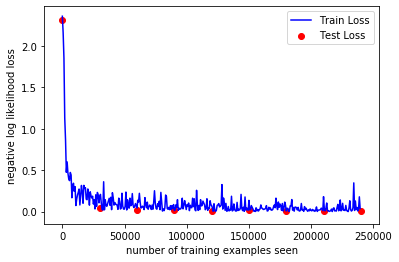

In [92]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## Inference Example With Trained Network

In [93]:
with torch.no_grad():
  output = model(example_data.to(device))
  output = output.cpu()

/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


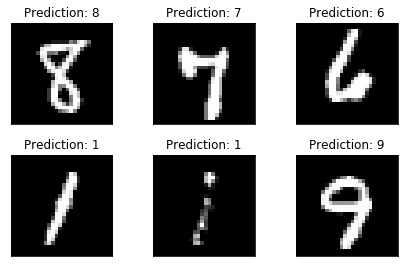

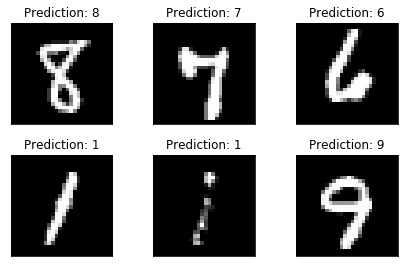

In [94]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Continue Training From Saved Checkpoint &amp; Final Training Results

In [ ]:
# continued_network = Net()
# continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
#                                 momentum=momentum)

# network_state_dict = torch.load(model_path)
# continued_network.load_state_dict(network_state_dict)

# optimizer_state_dict = torch.load(optimizer_path)
# continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
# def continue_training():
#   for i in range(4, 9):
#     test_counter.append(i*len(train_loader.dataset))
#     train(i)
#     test()

# %time continue_training()

In [ ]:
# fig = plt.figure()
# plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
# plt.xlabel('number of training examples seen')
# plt.ylabel('negative log likelihood loss')